<a href="https://colab.research.google.com/github/travislatchman/Autoencoders-for-Predictive-Epilepsy-Diagnosis/blob/main/autoencoder_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation learning with Autoencoders

we will solve a 2-class classification problem using Epilespy EEG data.



The dataset is available from https://zenodo.org/record/3684992

This dataset was generated with a motive to build predictive epilepsy diagnosis models. It was generated on a similar acquisition and settings i.e., sampling frequency, bandpass filtering and number of signals and time duration as
its much more famous counterpart - the University of Bonn dataset. It has overcome the limitations faced by the University of Bonn dataset, such as different EEG recording place (inter-cranial and scalp) for healthy and epileptic patients. All the data were taken exclusively using surface EEG electrodes.

Dataset for Training/Testing of Existing Models and Algorithms:

"This dataset was collected exclusively from scalp EEG taken from the same EEG machine and contains data of 30 subjects- 15 healthy and 15 epileptic subjects. Like the previous studies, the data of 5 healthy and 5 epileptic subjects was used for training and validation. The rest, i.e., the data of 10 healthy and 10 epilepsy subjects, was used for testing such that there was no overlap of subjects between the training/validation dataset and the testing dataset. In the training/validation dataset, forty EEG segments, of 23.6 seconds duration each, were utilized. In the testing dataset, twenty EEG segments of 23.6 seconds duration each per subject were utilized. Similar to the benchmark dataset, each class in the training/validation and test sets had 200 artifact-free EEG segments. Along with the duration, all the EEG segments in these datasets also met the bandwidth (0.5-40 Hz), sampling rate (173.6 Hz) and stationarity criteria of the benchmark dataset. This dataset is used as an alternate dataset to the benchmark dataset because benchmark dataset is data collected differently for the two classes (from scalp and from cortex). Thus, this dataset allows us to evaluate the performance of existing features and algorithms when trained and tested on a dataset collected consistently for the two classes, i.e., from the scalp."

S. Panwar, S. D. Joshi, A. Gupta and P. Agarwal, "Automated Epilepsy Diagnosis Using EEG With Test Set Evaluation," in IEEE Transactions on Neural Systems and Rehabilitation Engineering, vol. 27, no. 6, pp. 1106-1116, June 2019, doi: 10.1109/TNSRE.2019.2914603.
https://ieeexplore.ieee.org/abstract/document/8705361

In [ ]:
# load libraries; feel free to add more
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
! pip install wget
import wget
import keras
import glob
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torch
from torch.utils.data import Dataset, DataLoader


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create a new folder in your Google Drive to store the data, make that your current working directory and run the following code block to download all the dataset files.

In [ ]:
# Create a new folder called EEGDataSingleElectrode in my Google Drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/EEGDataSingleElectrode") # make that your current working directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download the dataset
for cat in ['E', 'H']:
  for pid in range(1,6):
    for filenum in range(1,41):
      dataFile = 'Train' + cat + str(pid) + '_' + str(filenum) + '.txt'
      if os.path.exists(dataFile):
        continue
      else:
        url = 'https://zenodo.org/record/3684992/files/' + dataFile + '?download=1'
        file_name = wget.download(url)
        print(file_name)

for cat in ['E', 'H']:
  for pid in range(1,11):
    for filenum in range(1,21):
      dataFile = cat + str(pid) + '_' + str(filenum) + '.txt'
      if os.path.exists(dataFile):
        continue
      else:
        url = 'https://zenodo.org/record/3684992/files/' + dataFile + '?download=1'
        file_name = wget.download(url)
        print(file_name)

**TASK 1: (Data Preparation)**

Please read the description of the dataset carefully (provided in the download link).

For this lab, we will not use the standard dataset partition suggested in the paper describing the corpus. We will employ all the files starting with 'Train' along with the files starting with E1 to E8 and H1 to H8 as our training data (that is a total of 26 participants.)

Files of subjects E9, E10, H9 and H10 (4 participants) will be our test data.

Load all the EEG files into two data matrices for train and test. The matrices should have dimensions N x S. Where is N is number of data points (~2880 for train and ~320 for test).
A single data point corresponds to a contiguous S=868 sample length (about 5s given the sampling rate of 173.6 Hz) from an EEG file. These 5 second segments are non-overlapping portions from the datasets.

The labels should be 0 or 1 (epilepsy or healthy). If you choose to store labels in other format like "one-hot encoding", y.shape would be Nx2.

Next, normalize all data to range of [-1,1]

Note: If you are having issues downloading the dataset from the link provided above, you can download it from this Google Drive folder

https://drive.google.com/file/d/1To0qBit_OVfC8ocV8xXSpHRh52Heq2lH/view?usp=share_link


In [ ]:
#get all the file names with train
Train_E = glob.glob('/content/drive/My Drive/EEGDataSingleElectrode/TrainE*')
Train_H = glob.glob('/content/drive/My Drive/EEGDataSingleElectrode/TrainH*')


#get all the file names with  E1 to E8 and H1 to H8
EH_1_8 = glob.glob('/content/drive/My Drive/EEGDataSingleElectrode/[EH][1-8]*')


#get the file path for E10 and H10
E_10 = glob.glob('/content/drive/My Drive/EEGDataSingleElectrode/E10*')
H_10 = glob.glob('/content/drive/My Drive/EEGDataSingleElectrode/H10*')

#get the file path for E10 and H10
E_9 = glob.glob('/content/drive/My Drive/EEGDataSingleElectrode/E9*')
H_9 = glob.glob('/content/drive/My Drive/EEGDataSingleElectrode/H9*')


E1_8 = glob.glob('/content/drive/My Drive/EEGDataSingleElectrode/E[1-8]*') # Path for files with E and numbers 1-8 in their name
H1_8 = glob.glob('/content/drive/My Drive/EEGDataSingleElectrode/H[1-8]*') # Path for files with H and numbers 1-8 in their name


#EH_1_8 will also have file paths of E10 and E10, therefore remove those file paths
E_H_1_8 = []
for i in EH_1_8:
  if  i in E_10:
    continue
  elif  i in H_10:
    continue
  else:
    E_H_1_8.append(i)


train_data_files = E_H_1_8 + Train_E+Train_H # Final train data paths
test_data_files = E_9+E_10+H_9+E_10

In [ ]:
# Initializing train matrix
train_matrix = np.array([]).reshape(0,868)
# Initializing test matrix
test_matrix = np.array([]).reshape(0,868)

In [ ]:
#train matrix
for file_path in train_data_files :
  file = np.loadtxt(file_path)
  for i in range(4):
    train_matrix = np.vstack((train_matrix, file[i*868:(i+1)*868]))

#test matrix
for file_path in test_data_files :
  file = np.loadtxt(file_path)
  for i in range(4):
    test_matrix = np.vstack((test_matrix, file[i*868:(i+1)*868]))

In [ ]:
print(train_matrix.shape)
print(test_matrix.shape)

(2880, 868)
(320, 868)


In [ ]:
#normalize the train and test matrix
# minimum and maximum values in train_matrix
min_val = np.min(train_matrix)
max_val = np.max(train_matrix)

# Normalize train_matrix to the range of [-1, 1]
train_matrix = (train_matrix - min_val) / (max_val - min_val) * 2 - 1

min_val = np.min(test_matrix)
max_val = np.max(test_matrix)

# Normalize train_matrix to the range of [-1, 1]
test_matrix = (test_matrix - min_val) / (max_val - min_val) * 2 - 1


In [ ]:
#labels
label_TrainE = np.zeros(4*len(Train_E))
label_TrainH = np.ones(4*len(Train_H))
label_E1_8 = np.zeros(4*(len(E1_8)-len(E_10)))
label_H1_8 = np.ones(4*(len(H1_8)-len(H_10)))
label = np.concatenate((label_E1_8,label_H1_8,label_TrainE,label_TrainH,),axis=0)

#Labels for Test
label_H = np.ones(4*(len(H_9)+len(H_10)))
label_E = np.zeros(4*(len(E_9)+len(E_10)))
test_label = np.concatenate((label_E,label_H),axis=0)

In [ ]:
label

array([0., 0., 0., ..., 1., 1., 1.])

**TASK 2: (Auto-encoder training)**
We will create an autoencoder based on the analysis methodology described in this paper.
https://www.sciencedirect.com/science/article/pii/S0957417420306114

Using Pythorch, create and train the auto-encoder specified in the paper.
An autoencoder is a specific type of a neural network, which is mainly designed to encode the input into a compressed and meaningful representation, and then decode it back such that the reconstructed input is similar as possible to the original one.
We will refer to this model as *original auto-encoder* in this lab.
We provide the Table 9 from the paper which specifies all details of the network below. Choose MSE (mean squared error) as loss function.
Your loss must decrease with epochs.

Hint 1: It would be useful to use `summary(autoencoder, input_size=())` to verify if your architecture is correct.

Hint 2: Convolutional layers need to be modified such that they do not modify the length of input signal. Also, ensure the output of network is same shape as input.

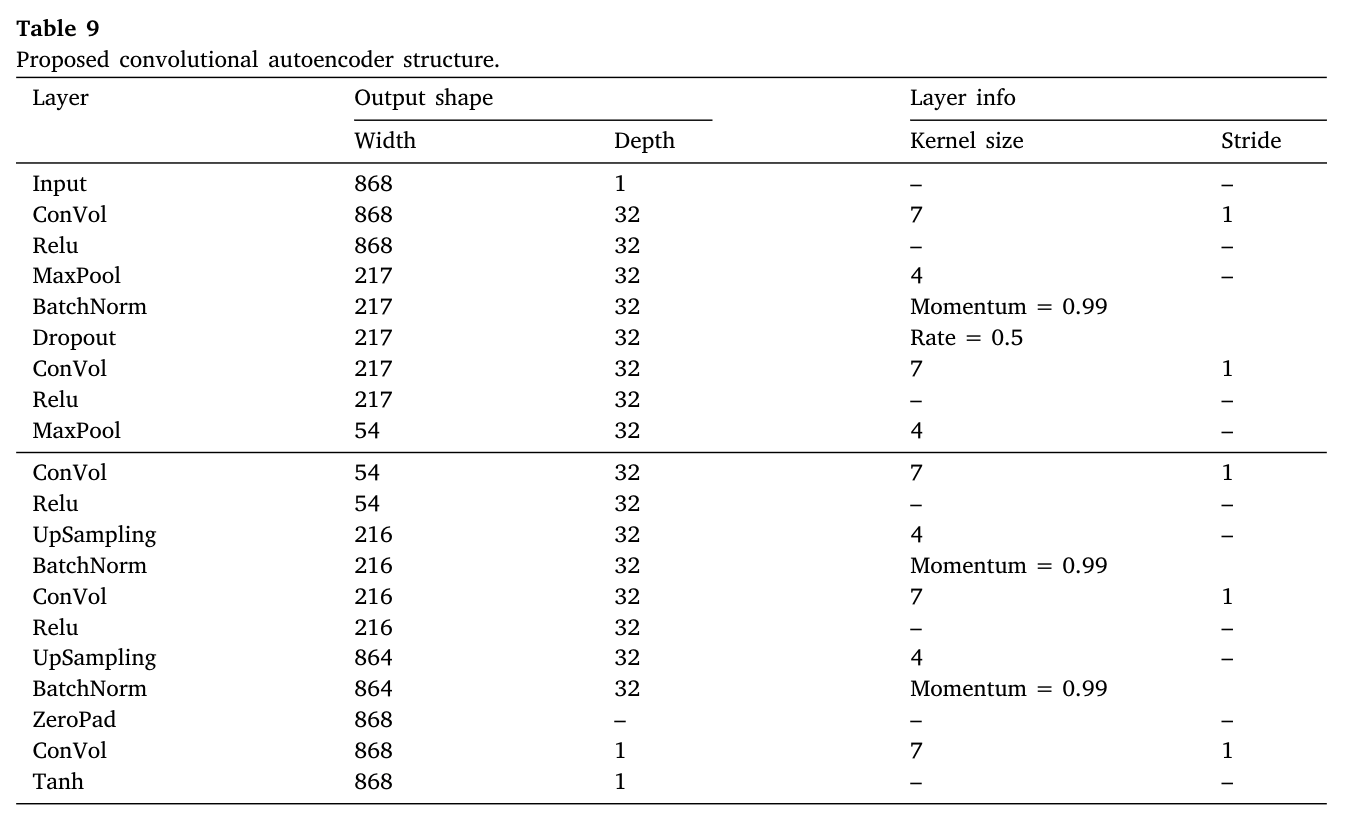

In [ ]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=None),
            nn.BatchNorm1d(32, momentum=0.99),
            nn.Dropout(p=0.5),
            nn.Conv1d(32, 32, kernel_size=7, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=None)
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=7, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=4),
            nn.BatchNorm1d(32, momentum=0.99),
            nn.Conv1d(32, 32, kernel_size=7, padding='same'),
            nn.ReLU(),
            nn.Upsample(scale_factor=4),
            nn.BatchNorm1d(32, momentum=0.99),
            nn.ZeroPad2d((2, 2)),
            nn.Conv1d(32, 1, kernel_size=7, padding='same'),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)

        return x


In [ ]:
# The following packages using to summary model
from torchvision import models
from torchsummary import summary

# You codes here to show your model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

summary(model, input_size=(1, 868))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 868]             256
              ReLU-2              [-1, 32, 868]               0
         MaxPool1d-3              [-1, 32, 217]               0
       BatchNorm1d-4              [-1, 32, 217]              64
           Dropout-5              [-1, 32, 217]               0
            Conv1d-6              [-1, 32, 217]           7,200
              ReLU-7              [-1, 32, 217]               0
         MaxPool1d-8               [-1, 32, 54]               0
            Conv1d-9               [-1, 32, 54]           7,200
             ReLU-10               [-1, 32, 54]               0
         Upsample-11              [-1, 32, 216]               0
      BatchNorm1d-12              [-1, 32, 216]              64
           Conv1d-13              [-1, 32, 216]           7,200
             ReLU-14              [-1, 

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data) # Convert data matrix to torch tensor
        self.labels = torch.tensor(labels) # Convert labels to torch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        label_item = self.labels[idx]
        data_item = data_item.unsqueeze(0)  # Add a dimension for the channel
        return data_item, label_item


# Instantiate the custom dataset
train_dataset = CustomDataset(train_matrix, label)
test_dataset = CustomDataset(test_matrix, test_label)

# Define batch size and other hyperparameters
batch_size = 64 # Choose your desired batch size
# Create data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
def train(autoencoder, train_loader, optimizer, criterion, num_epochs):
  losses = []
  for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
      inputs = data[0].float().to(device) # Convert input tensor to float and same device as model
      optimizer.zero_grad()
      outputs = autoencoder(inputs)
      loss = criterion(outputs, inputs)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
  plt.plot(losses)
  plt.title("Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()


Epoch 1/50, Training Loss: 0.0145
Epoch 2/50, Training Loss: 0.0041
Epoch 3/50, Training Loss: 0.0033
Epoch 4/50, Training Loss: 0.0031
Epoch 5/50, Training Loss: 0.0029
Epoch 6/50, Training Loss: 0.0027
Epoch 7/50, Training Loss: 0.0024
Epoch 8/50, Training Loss: 0.0023
Epoch 9/50, Training Loss: 0.0022
Epoch 10/50, Training Loss: 0.0021
Epoch 11/50, Training Loss: 0.0020
Epoch 12/50, Training Loss: 0.0021
Epoch 13/50, Training Loss: 0.0018
Epoch 14/50, Training Loss: 0.0017
Epoch 15/50, Training Loss: 0.0017
Epoch 16/50, Training Loss: 0.0016
Epoch 17/50, Training Loss: 0.0015
Epoch 18/50, Training Loss: 0.0015
Epoch 19/50, Training Loss: 0.0014
Epoch 20/50, Training Loss: 0.0014
Epoch 21/50, Training Loss: 0.0014
Epoch 22/50, Training Loss: 0.0013
Epoch 23/50, Training Loss: 0.0013
Epoch 24/50, Training Loss: 0.0012
Epoch 25/50, Training Loss: 0.0012
Epoch 26/50, Training Loss: 0.0013
Epoch 27/50, Training Loss: 0.0012
Epoch 28/50, Training Loss: 0.0012
Epoch 29/50, Training Loss: 0

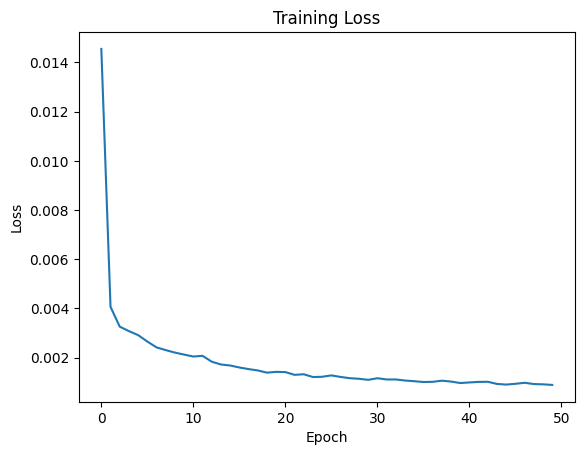

In [ ]:
# Train your autoencoder
train(model, train_loader, optimizer, criterion, num_epochs = 50)

**TASK 3: (Visualization of reconstruction)** Let x be a 868-sample long data point from your test set, e() be encoder, d() be decoder. The reconstuction/auto-encoding of x is given by d(e(x)) i.e. simply forward pass of x through the auto-encoder. On separate figures, (1) plot one signal from test set and its reconstructed version.

Also, answer the following questions:
(2) What is the dimension of encoding $z$ (learned representation) of x? If you find the encoding $z$ to be multi-dimensional i.e. `len(z.shape) > 1`, then the encoding dimension is defined as `np.prod(z.shape)`
 (3) Comment on the relation between the obtained dimension of learned representation and reconstructed signal quality.

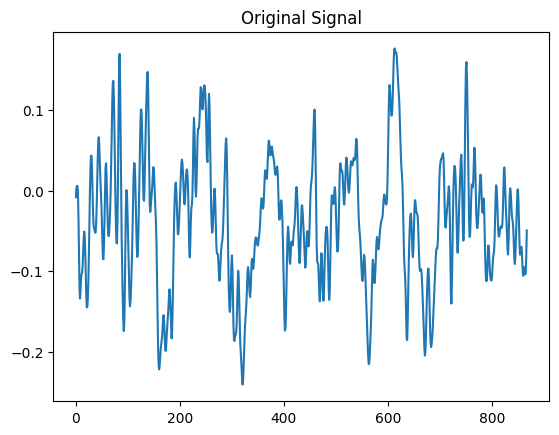

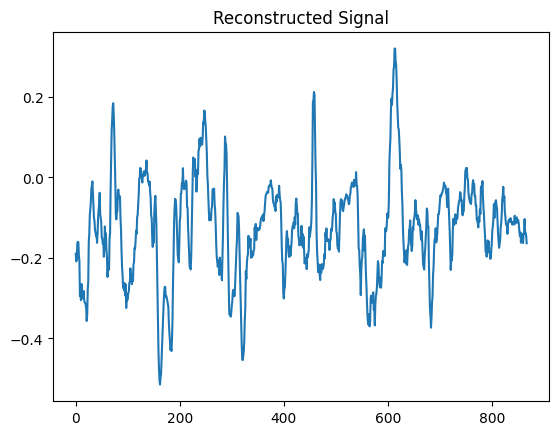

In [ ]:
# Function to get the encoding z
def encode(x, autoencoder):
    with torch.no_grad():
        x_encoded = autoencoder.encoder(x)
    return x_encoded

# Encode and decode a signal from the test set
x = test_dataset[0][0].unsqueeze(0).float().to(device)
z = encode(x, model)
x_reconstructed = model(x)

# Move tensors to CPU, detach them from the computation graph, and remove batch and channel dimensions for plotting
x = x.squeeze().cpu().detach().numpy()
x_reconstructed = x_reconstructed.squeeze().cpu().detach().numpy()

# Plot the original signal and its reconstruction
plt.figure()
plt.plot(x)
plt.title("Original Signal")
plt.figure()
plt.plot(x_reconstructed)
plt.title("Reconstructed Signal")
plt.show()


In [ ]:
print(len(z.shape) > 1)
encoding_dim = np.prod(z.shape[1:])
print("Encoding dimension:", encoding_dim)
print(z.shape)

True
Encoding dimension: 1728
torch.Size([1, 32, 54])


In [ ]:
print(f'Relation between dimension of output_vector and learned representation vector: {round(np.prod(z.shape)/np.prod(x.shape))}')


Relation between dimension of output_vector and learned representation vector: 2


(3) Comment on the relation between the obtained dimension of learned representation and reconstructed signal quality.

**Answer**:the results shows that the ratio is 2. This means that the learned representation (encoding) is twice smaller than the original input signal. So, the autoencoder has compressed the input signal by a factor of 2 in this specific case. The goal of an autoencoder is to learn a compact representation of the input data while still being able to reconstruct the data with minimal loss of information. In this case, the autoencoder has achieved a compression factor of 2, which means it has reduced the size of the input data by half while still being able to reconstruct the input signal reasonably well.

**TASK 4 (Training classifier)**: Discarding the decoder, append a simple classifier at the end of your trained encoder. The classifier (excluding your encoder) is a M=100 unit dense layer followed by your favorite activation function followed by 2-class softmax classification. Encoder must be frozen in this training. Report accuracy on test set.

In [ ]:
class EncoderClassifier(nn.Module):
    def __init__(self, encoder):
        super(EncoderClassifier, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
            nn.Linear(32 * 54, 100),
            nn.ReLU(),
            nn.Linear(100, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

# Initialize the model and freeze the encoder
model_classifier = EncoderClassifier(model.encoder).to(device)
for param in model_classifier.encoder.parameters():
    param.requires_grad = False

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_classifier.classifier.parameters(), lr=0.001)



Epoch 1/100, Training Loss: 0.6221
Epoch 2/100, Training Loss: 0.5298
Epoch 3/100, Training Loss: 0.4957
Epoch 4/100, Training Loss: 0.5007
Epoch 5/100, Training Loss: 0.4894
Epoch 6/100, Training Loss: 0.4782
Epoch 7/100, Training Loss: 0.4735
Epoch 8/100, Training Loss: 0.4796
Epoch 9/100, Training Loss: 0.4668
Epoch 10/100, Training Loss: 0.4605
Epoch 11/100, Training Loss: 0.4614
Epoch 12/100, Training Loss: 0.4642
Epoch 13/100, Training Loss: 0.4533
Epoch 14/100, Training Loss: 0.4470
Epoch 15/100, Training Loss: 0.4568
Epoch 16/100, Training Loss: 0.4456
Epoch 17/100, Training Loss: 0.4411
Epoch 18/100, Training Loss: 0.4386
Epoch 19/100, Training Loss: 0.4256
Epoch 20/100, Training Loss: 0.4326
Epoch 21/100, Training Loss: 0.4288
Epoch 22/100, Training Loss: 0.4439
Epoch 23/100, Training Loss: 0.4284
Epoch 24/100, Training Loss: 0.4456
Epoch 25/100, Training Loss: 0.4304
Epoch 26/100, Training Loss: 0.4221
Epoch 27/100, Training Loss: 0.4212
Epoch 28/100, Training Loss: 0.4372
E

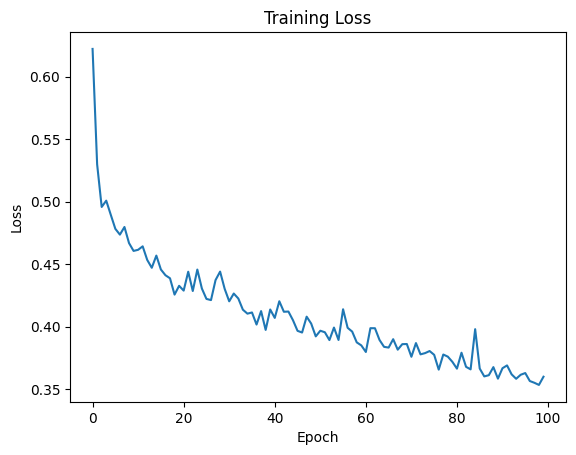

Accuracy on test set: 54.37%


In [ ]:
# Training function for the classifier
def train_classifier(model, train_loader, optimizer, criterion, num_epochs):
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.float().to(device), targets.long().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

# Train the classifier
train_classifier(model_classifier, train_loader, optimizer, criterion, num_epochs=100)

# Evaluation function for the classifier
def evaluate_classifier(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.float().to(device), targets.long().to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    print(f"Accuracy on test set: {accuracy:.2%}")

# Evaluate the classifier
evaluate_classifier(model_classifier, test_loader)


**TASK 5 (Modifying bottleneck of auto-encoder)**: Let us treat K (encoded dimension) a as hyper-parameter. Your goal is to ensure K is approximately half of signal length i.e. 868/2 = 434. It is OK if your reduced dimension is in +/-10% range of 434. You will accomplish this by modifying/adding/removing ONLY the following three types of layers: Upsampling, ZeroPadding, and MaxPooling layer. Like previous tasks, first train the autoencoder, then train the subsequent classifier (keeping encoder frozen), and finally report test accuracy. The classifier architecture remains same as before. Also, display a test image and its reconstruction using this auto-encoder. What is your comment on it?

In [ ]:
class Autoencoder_v2(nn.Module):
    def __init__(self):
        super(Autoencoder_v2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.BatchNorm1d(32, momentum=0.99),
            nn.Dropout(p=0.5),
            nn.Conv1d(32, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1)
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm1d(32, momentum=0.99),
            nn.Conv1d(32, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Upsample(scale_factor=1),
            nn.BatchNorm1d(32, momentum=0.99),
            nn.ConstantPad1d(padding=2, value=0),
            nn.Conv1d(32, 1, kernel_size=7, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)

        return x


In [ ]:
modelV2 = Autoencoder_v2().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(modelV2.parameters(), lr=0.01)


In [ ]:

# You codes here to show your model
summary(modelV2, input_size=(1, 868))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 868]             256
              ReLU-2              [-1, 32, 868]               0
         MaxPool1d-3              [-1, 32, 434]               0
       BatchNorm1d-4              [-1, 32, 434]              64
           Dropout-5              [-1, 32, 434]               0
            Conv1d-6              [-1, 32, 434]           7,200
              ReLU-7              [-1, 32, 434]               0
         MaxPool1d-8              [-1, 32, 432]               0
            Conv1d-9              [-1, 32, 432]           7,200
             ReLU-10              [-1, 32, 432]               0
         Upsample-11              [-1, 32, 864]               0
      BatchNorm1d-12              [-1, 32, 864]              64
           Conv1d-13              [-1, 32, 864]           7,200
             ReLU-14              [-1, 

In [ ]:
def train(autoencoder, train_loader, optimizer, criterion, num_epochs):
  losses = []
  for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
      inputs = data[0].float().to(device) # Convert input tensor to float and same device as model
      optimizer.zero_grad()
      outputs = autoencoder(inputs)
      loss = criterion(outputs, inputs)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
  plt.plot(losses)
  plt.title("Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

Epoch 1/50, Training Loss: 0.0311
Epoch 2/50, Training Loss: 0.0018
Epoch 3/50, Training Loss: 0.0013
Epoch 4/50, Training Loss: 0.0012
Epoch 5/50, Training Loss: 0.0015
Epoch 6/50, Training Loss: 0.0011
Epoch 7/50, Training Loss: 0.0011
Epoch 8/50, Training Loss: 0.0009
Epoch 9/50, Training Loss: 0.0010
Epoch 10/50, Training Loss: 0.0014
Epoch 11/50, Training Loss: 0.0012
Epoch 12/50, Training Loss: 0.0012
Epoch 13/50, Training Loss: 0.0009
Epoch 14/50, Training Loss: 0.0008
Epoch 15/50, Training Loss: 0.0009
Epoch 16/50, Training Loss: 0.0013
Epoch 17/50, Training Loss: 0.0014
Epoch 18/50, Training Loss: 0.0008
Epoch 19/50, Training Loss: 0.0005
Epoch 20/50, Training Loss: 0.0005
Epoch 21/50, Training Loss: 0.0005
Epoch 22/50, Training Loss: 0.0004
Epoch 23/50, Training Loss: 0.0004
Epoch 24/50, Training Loss: 0.0004
Epoch 25/50, Training Loss: 0.0004
Epoch 26/50, Training Loss: 0.0003
Epoch 27/50, Training Loss: 0.0004
Epoch 28/50, Training Loss: 0.0003
Epoch 29/50, Training Loss: 0

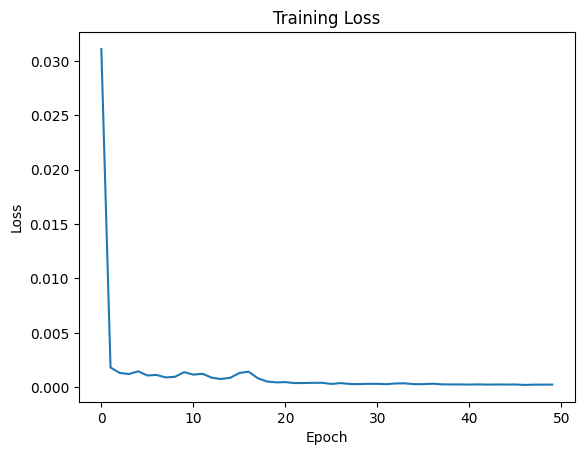

In [ ]:
train(modelV2, train_loader, optimizer, criterion, 50)

In [ ]:
encoder = modelV2.encoder
for param in encoder.parameters():
    param.requires_grad = False


Epoch 1/100, Training Loss: 0.7384
Epoch 2/100, Training Loss: 0.6838
Epoch 3/100, Training Loss: 0.6490
Epoch 4/100, Training Loss: 0.6257
Epoch 5/100, Training Loss: 0.6211
Epoch 6/100, Training Loss: 0.6121
Epoch 7/100, Training Loss: 0.5985
Epoch 8/100, Training Loss: 0.5854
Epoch 9/100, Training Loss: 0.5748
Epoch 10/100, Training Loss: 0.5785
Epoch 11/100, Training Loss: 0.5601
Epoch 12/100, Training Loss: 0.5492
Epoch 13/100, Training Loss: 0.5489
Epoch 14/100, Training Loss: 0.5486
Epoch 15/100, Training Loss: 0.5331
Epoch 16/100, Training Loss: 0.5378
Epoch 17/100, Training Loss: 0.5347
Epoch 18/100, Training Loss: 0.5180
Epoch 19/100, Training Loss: 0.5214
Epoch 20/100, Training Loss: 0.5143
Epoch 21/100, Training Loss: 0.5151
Epoch 22/100, Training Loss: 0.5065
Epoch 23/100, Training Loss: 0.5042
Epoch 24/100, Training Loss: 0.5011
Epoch 25/100, Training Loss: 0.4922
Epoch 26/100, Training Loss: 0.5074
Epoch 27/100, Training Loss: 0.5092
Epoch 28/100, Training Loss: 0.4965
E

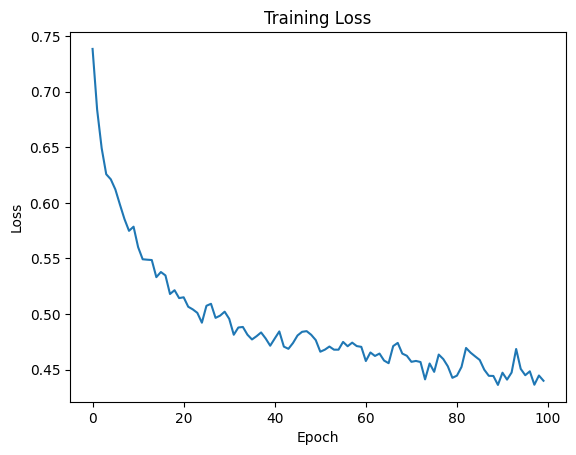

In [ ]:
# Define the classifier architecture
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(32 * 432, 128),  # Update input size here
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten tensor
        x = self.classifier(x)
        return x


# Train the classifier
classifier = Classifier().to(device)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=0.0001)
classifier_criterion = nn.CrossEntropyLoss()
def train_classifier(encoder, classifier, train_loader, optimizer, criterion, num_epochs):
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            inputs = data.float().to(device)
            targets = targets.long().to(device)

            # Encode the inputs using the encoder
            encoded_inputs = encoder(inputs)

            # Train the classifier with encoded inputs
            optimizer.zero_grad()
            outputs = classifier(encoded_inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

# Train the classifier

train_classifier(encoder, classifier, train_loader, classifier_optimizer, classifier_criterion, 100)


In [ ]:
def test_accuracy(encoder, classifier, test_loader):
    encoder.eval()
    classifier.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            inputs = data.float().to(device)
            targets = targets.long().to(device)

            # Encode the inputs using the encoder
            encoded_inputs = encoder(inputs)

            # Get the classifier's predictions
            outputs = classifier(encoded_inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Calculate the test accuracy
test_accuracy(encoder, classifier, test_loader)


Test Accuracy: 50.31%


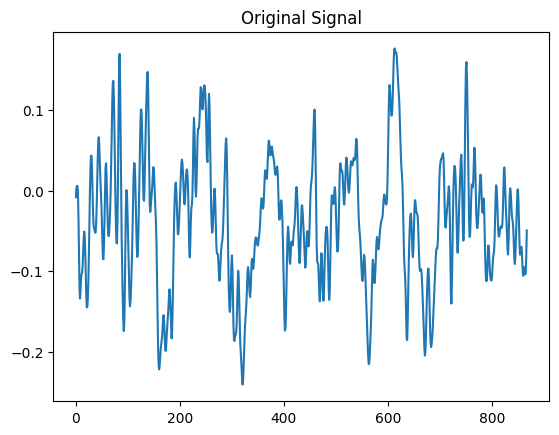

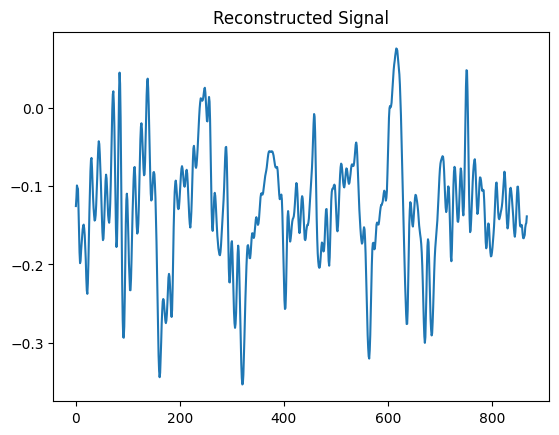

In [ ]:
# Function to get the encoding z
def encode(x, autoencoder):
    with torch.no_grad():
        x_encoded = autoencoder.encoder(x)
    return x_encoded

# Encode and decode a signal from the test set
x = test_dataset[0][0].unsqueeze(0).float().to(device)
z = encode(x, modelV2)
x_reconstructed = modelV2(x)

# Move tensors to CPU, detach them from the computation graph, and remove batch and channel dimensions for plotting
x = x.squeeze().cpu().detach().numpy()
x_reconstructed = x_reconstructed.squeeze().cpu().detach().numpy()

# Plot the original signal and its reconstruction
plt.figure()
plt.plot(x)
plt.title("Original Signal")
plt.figure()
plt.plot(x_reconstructed)
plt.title("Reconstructed Signal")
plt.show()

In [ ]:
print(len(z.shape) > 1)
encoding_dim = np.prod(z.shape[1:])
print("Encoding dimension:", encoding_dim)
print(z.shape)

True
Encoding dimension: 13824
torch.Size([1, 32, 432])


In [ ]:
print(f'Relation between dimension of output_vector and learned representation vector: {round(np.prod(z.shape)/np.prod(x.shape))}')

Relation between dimension of output_vector and learned representation vector: 16


What is your comment on it?

**Answer:** After the modification of the autoencoder, the encoded dimension of the output vector was increased to 16. This means that the encoder is now compressing the input signal into a 16-dimensional latent space. This higher dimensional representation should contain more information about the input signal than the 2-dimensional representation, making it easier for the classifier to distinguish between different input signals.













**TASK 6**:  
Plot the t-SNE visualization (https://opentsne.readthedocs.io/) of the representations of training data learned by the auto-encoders of PART 2, 5, and 6. Use different color for data from different classes.
Repeat this visualization but now use a different color per participant (each participant has several files and frames and will have several points in the TSNE plot). Comment on your results.

In [ ]:
# You are welcome to use other t-SNE package you are familiar with
! pip install opentsne
from openTSNE import TSNE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


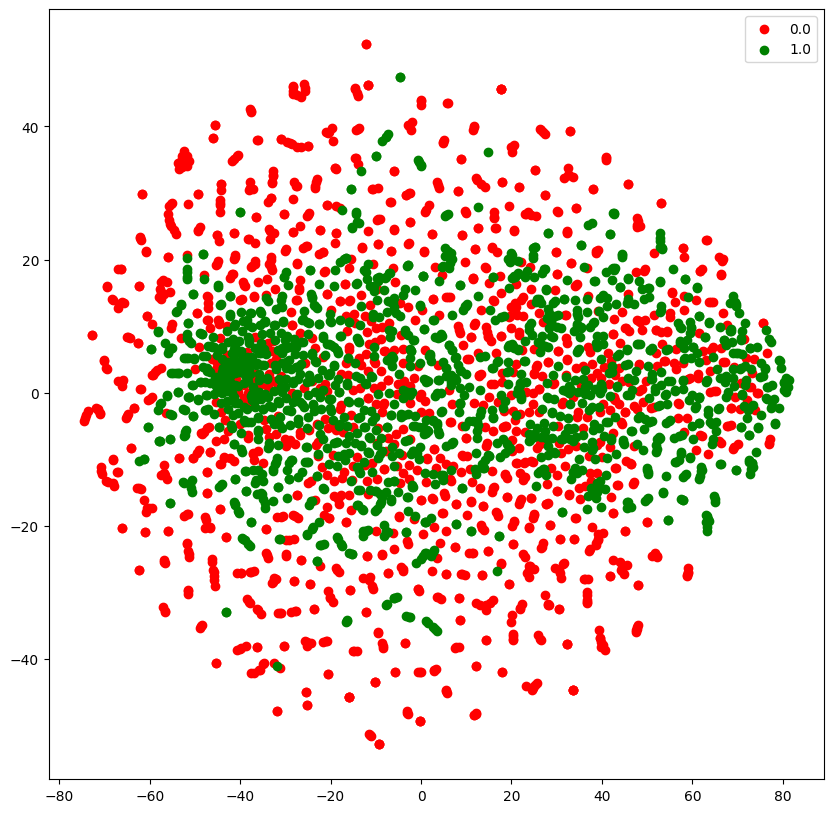

In [ ]:
from sklearn.manifold import TSNE
# Create dataloader for training dataset
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Extract encoded representations of training data
encoded_train_data = []
train_labels = []
with torch.no_grad():
    for data, label in train_loader:
        data = data.float().to(device)

        label = label.numpy()
        encoded = model.encoder(data).squeeze(0)
        encoded = encoded.reshape(-1).cpu().numpy()
        encoded_train_data.append(encoded)
        train_labels.append(label)

encoded_train_data = np.array(encoded_train_data).reshape((2880, 1728))
train_labels = np.array(train_labels).squeeze(1)

# Use t-SNE to reduce dimensionality of encoded data to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
encoded_train_data_tsne = tsne.fit_transform(encoded_train_data)


# Plot t-SNE visualization with different colors for different classes
plt.figure(figsize=(10, 10))
colors = ['r', 'g'] # specify colors for each class
for i, label in enumerate(np.unique(train_labels)):
    idx = np.where(train_labels == label)[0]
    plt.scatter(encoded_train_data_tsne[idx, 0], encoded_train_data_tsne[idx, 1], c=colors[i], label=label)

plt.legend()
plt.show()


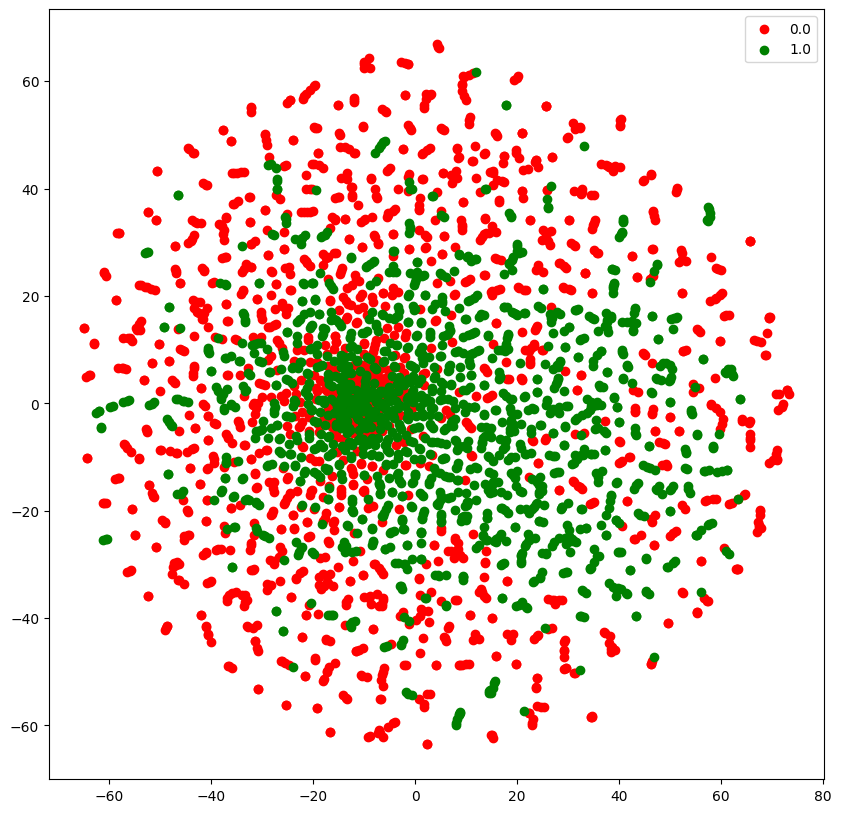

In [ ]:

# Extract encoded representations of training data
encoded_train_data = []
train_labels = []
with torch.no_grad():
    for data, label in train_loader:
        data = data.float().to(device)

        label = label.numpy()
        encoded = modelV2.encoder(data).squeeze(0)
        encoded = encoded.reshape(-1).cpu().numpy()
        encoded_train_data.append(encoded)
        train_labels.append(label)

encoded_train_data = np.array(encoded_train_data).reshape((2880, 13824))
train_labels = np.array(train_labels).squeeze(1)

# Use t-SNE to reduce dimensionality of encoded data to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
encoded_train_data_tsne = tsne.fit_transform(encoded_train_data)


# Plot t-SNE visualization with different colors for different classes
plt.figure(figsize=(10, 10))
colors = ['r', 'g'] # specify colors for each class
for i, label in enumerate(np.unique(train_labels)):
    idx = np.where(train_labels == label)[0]
    plt.scatter(encoded_train_data_tsne[idx, 0], encoded_train_data_tsne[idx, 1], c=colors[i], label=label)

plt.legend()
plt.show()


In [ ]:
# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, data_files, labels):
        self.data_files = data_files
        self.labels = torch.tensor(labels)

        self.patient_ids = self.get_patient_ids()  # get patient IDs

    def __len__(self):
        return len(self.data_files) * 4

    def __getitem__(self, idx):
        file_idx = idx // 4  # get index of file
        data = np.loadtxt(self.data_files[file_idx])
        label = self.labels[file_idx]
        patient_id = self.patient_ids[idx]  # get patient ID for current sample
        data = torch.tensor(data[(idx % 4) * 868 : (idx % 4 + 1) * 868])
        data = data.unsqueeze(0)  # Add a dimension for the channel
        return data, label, patient_id

    def get_patient_ids(self):
        patient_ids = []
        for file in self.data_files:
            patient_id = re.findall('\d+', file)[0]  # extract patient ID from file name
            patient_ids += [patient_id] * 4  # add patient ID four times (for each segment)
        return patient_ids

In [ ]:
train_data_files = [f for f in train_data_files if os.path.isfile(f)]

In [ ]:
label_TrainE = np.zeros(4*len(Train_E))
label_TrainH = np.ones(4*len(Train_H))
label_E1_8 = np.zeros(4*(len(E1_8)-len(E_10)))
label_H1_8 = np.ones(4*(len(H1_8)-len(H_10)))
label = np.concatenate((label_E1_8,label_H1_8,label_TrainE,label_TrainH,),axis=0)

#Labels for Test
label_H = np.ones(4*(len(H_9)+len(H_10)))
label_E = np.zeros(4*(len(E_9)+len(E_10)))
test_label = np.concatenate((label_E,label_H),axis=0)

In [ ]:
import re
# Create CustomDataset and DataLoader objects
train_dataset = CustomDataset(train_data_files, label)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Extract encoded representations of training data
encoded_train_data = []
train_labels = []
patient_ids = []
with torch.no_grad():
    for data, label, patient_id in train_loader:
        data = data.float().to(device)

        label = label.numpy()
        encoded = modelV2.encoder(data).squeeze(0)
        encoded = encoded.reshape(-1).cpu().numpy()
        encoded_train_data.append(encoded)
        train_labels.append(label)
        patient_ids.append(patient_id)

encoded_train_data = np.array(encoded_train_data).reshape((2880, 13824))
train_labels = np.array(train_labels).squeeze(1)
patient_ids = np.array(patient_ids).squeeze(1)

# Use t-SNE to reduce dimensionality of encoded data to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
encoded_train_data_tsne = tsne.fit_transform(encoded_train_data)

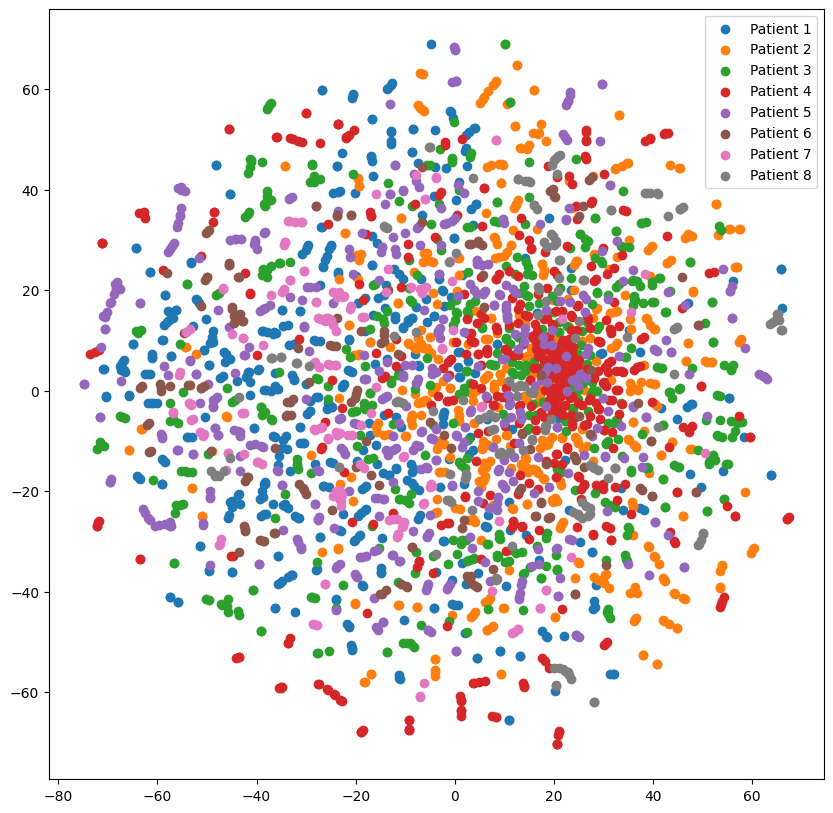

In [ ]:
# Plot t-SNE visualization with different colors for different patients
plt.figure(figsize=(10, 10))
for i, pid in enumerate(np.unique(patient_ids)):
    idx = np.where(patient_ids == pid)[0]
    plt.scatter(encoded_train_data_tsne[idx, 0], encoded_train_data_tsne[idx, 1], label=f'Patient {pid}')

plt.legend()
plt.show()

In [ ]:
label_TrainE = np.zeros(4*len(Train_E))
label_TrainH = np.ones(4*len(Train_H))
label_E1_8 = np.zeros(4*(len(E1_8)-len(E_10)))
label_H1_8 = np.ones(4*(len(H1_8)-len(H_10)))
label = np.concatenate((label_E1_8,label_H1_8,label_TrainE,label_TrainH,),axis=0)

In [ ]:
# Create CustomDataset and DataLoader objects
train_dataset = CustomDataset(train_data_files, label)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Extract encoded representations of training data
encoded_train_data = []
train_labels = []
patient_ids = []
with torch.no_grad():
    for data, label, patient_id in train_loader:
        data = data.float().to(device)

        label = label.numpy()
        encoded = model.encoder(data).squeeze(0)
        encoded = encoded.reshape(-1).cpu().numpy()
        encoded_train_data.append(encoded)
        train_labels.append(label)
        patient_ids.append(patient_id)

encoded_train_data = np.array(encoded_train_data).reshape((2880, 1728))
train_labels = np.array(train_labels).squeeze(1)
patient_ids = np.array(patient_ids).squeeze(1)

# Use t-SNE to reduce dimensionality of encoded data to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
encoded_train_data_tsne = tsne.fit_transform(encoded_train_data)

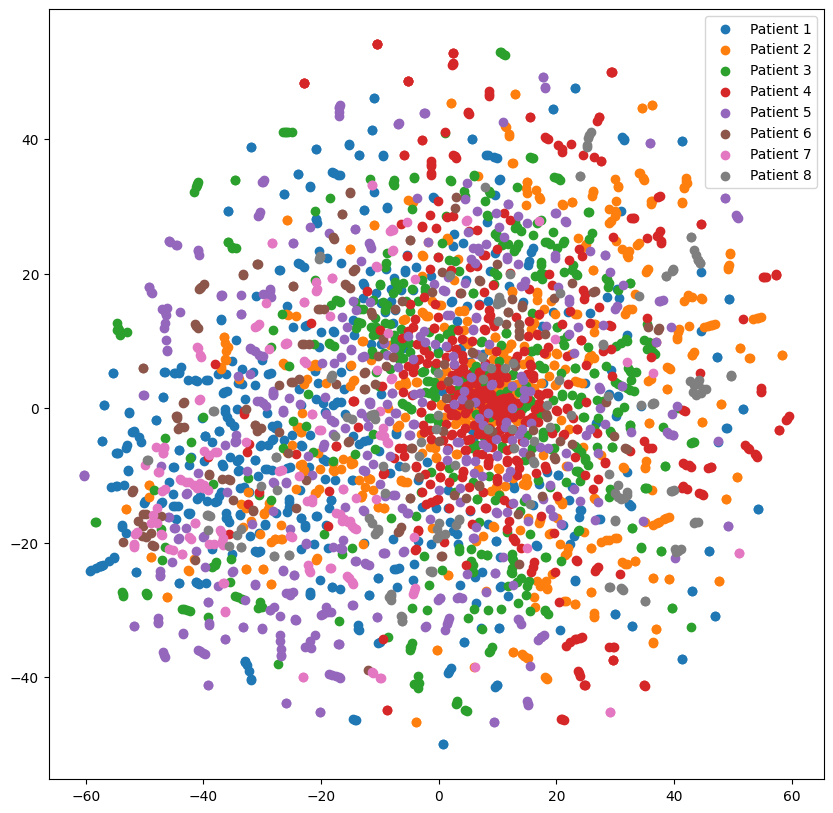

In [ ]:
# Plot t-SNE visualization with different colors for different patients
plt.figure(figsize=(10, 10))
for i, pid in enumerate(np.unique(patient_ids)):
    idx = np.where(patient_ids == pid)[0]
    plt.scatter(encoded_train_data_tsne[idx, 0], encoded_train_data_tsne[idx, 1], label=f'Patient {pid}')

plt.legend()
plt.show()

**Comment on your results.**

**Answer**: A t-SNE visualization of trained data from an autoencoder can provide useful insights into the quality of the learned representations and areas that could be improved. From the plots, it is evident that the healthy-labeled data points are clustered together in both cases. However, in the second autoencoder's graph, the red points are more tightly clustered than in the first, suggesting that it has learned more meaningful representations of the data. Additionally, we can infer from the second autoencoder's graph that most of the outliers correspond to epilepsy-labeled data points. There is no clear additional conclusion regarding the model's ability to learn meaningful representations of patient-labeled data from the graphs.

Considering the size of the dataset we used in this lab, do you think the way we split this dataset into training and test dataset is a good choice？Analyze whether the dataset we used in this lab requires any specific validation in a real experiment or if the split we have done in this lab was enough.

**Answer**: The way we split the dataset into training and test dataset is not ideal because it only includes a small subset of the available participants, and the partition is not based on any specific criteria such as age or gender. Additionally, the test dataset only includes four participants, which may not be representative of the overall population.

In a real experiment, a more comprehensive and representative sample of participants should be used, and the partition should be based on specific criteria such as age, gender, and epilepsy history. The split we have done in this lab may not be sufficient to provide a reliable evaluation of the model's performance on new, unseen data. Therefore, additional validation methods such as cross-validation or a separate validation dataset may be necessary.



In the previous tasks, you have calculated the *frame-wise* validation accuracy. Calculate now the *file-wise* and *participant-wise* validation accuracy of the classifiers in parts 4 and 5, considering that each file has several frames. Are the *file-wise* and *participant-wise* accuracy better or worse than the *frame-wise* one?


Hint: a very simple method to obtain per-file accuracy is to average the scores provided by the NN for all the frames of a single file and then compare it to a threshold, usually 0.5. However, you might obtain higher accuracy if you select other threshold (hint-to-the-hint: maybe you can calculate an EER threshold observing the scores of the training files.)
Hint II: Another option to obtain *file-wise* scores would be to use sequence-to-vector classifiers with the latent feature vectors, such as LSTM.


In [ ]:
# Initializing train matrix
train_matrix = np.array([]).reshape(0,868)
# Initializing test matrix
test_matrix = np.array([]).reshape(0,868)

#train matrix
for file_path in train_data_files :
  file = np.loadtxt(file_path)
  for i in range(4):
    train_matrix = np.vstack((train_matrix, file[i*868:(i+1)*868]))

#test matrix
for file_path in test_data_files :
  file = np.loadtxt(file_path)
  for i in range(4):
    test_matrix = np.vstack((test_matrix, file[i*868:(i+1)*868]))
#normalize the train and test matrix
# minimum and maximum values in train_matrix
min_val = np.min(train_matrix)
max_val = np.max(train_matrix)

# Normalize train_matrix to the range of [-1, 1]
train_matrix = (train_matrix - min_val) / (max_val - min_val) * 2 - 1

min_val = np.min(test_matrix)
max_val = np.max(test_matrix)

# Normalize train_matrix to the range of [-1, 1]
test_matrix = (test_matrix - min_val) / (max_val - min_val) * 2 - 1
#labels
label_TrainE = np.zeros(4*len(Train_E))
label_TrainH = np.ones(4*len(Train_H))
label_E1_8 = np.zeros(4*(len(E1_8)-len(E_10)))
label_H1_8 = np.ones(4*(len(H1_8)-len(H_10)))
label = np.concatenate((label_E1_8,label_H1_8,label_TrainE,label_TrainH,),axis=0)

#Labels for Test
label_H = np.ones(4*(len(H_9)+len(H_10)))
label_E = np.zeros(4*(len(E_9)+len(E_10)))
test_label = np.concatenate((label_E,label_H),axis=0)

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data) # Convert data matrix to torch tensor
        self.labels = torch.tensor(labels) # Convert labels to torch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        label_item = self.labels[idx]
        data_item = data_item.unsqueeze(0)  # Add a dimension for the channel
        return data_item, label_item


In [ ]:
# Instantiate the custom dataset

test_dataset = CustomDataset(test_matrix, test_label)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


def predict_filewise(model, data_loader):
    model.eval()
    file_scores = []
    for inputs, labels in data_loader:
        inputs = inputs.float().to(device)
        outputs = model(inputs)
        score = torch.mean(torch.abs(inputs - outputs)).item()
        file_scores.append(score)
    return np.array(file_scores)

file_scores = predict_filewise(model, test_loader)
file_pred_labels = (file_scores >= 0.5).astype(int)
file_acc = np.mean(file_pred_labels == test_label)
print('File-wise accuracy Model 1:', file_acc)
file_scores = predict_filewise(modelV2, test_loader)
file_pred_labels = (file_scores >= 0.5).astype(int)
file_acc = np.mean(file_pred_labels == test_label)
print('File-wise accurac Model 2:', file_acc)

File-wise accuracy Model 1: 0.5
File-wise accurac Model 2: 0.5


In [ ]:
def predict_participantwise(model, data_loader):
    model.eval()
    participant_scores = {}
    for inputs, labels in data_loader:
        inputs = inputs.float().to(device)
        outputs = model(inputs)
        score = torch.mean(torch.abs(inputs - outputs)).item()
        pid = int(inputs[0].squeeze()[-1].item())

        if pid not in participant_scores:
            participant_scores[pid] = []
        participant_scores[pid].append(score)
    return {pid: np.mean(scores) for pid, scores in participant_scores.items()}

participant_scores = predict_participantwise(model, test_loader)
participant_pred_labels = (np.array(list(participant_scores.values())) >= 0.5).astype(int)
participant_acc = np.mean(participant_pred_labels == test_label)
print('Participant-wise accuracy Model 1:', participant_acc)
participant_scores = predict_participantwise(modelV2, test_loader)
participant_pred_labels = (np.array(list(participant_scores.values())) >= 0.5).astype(int)
participant_acc = np.mean(participant_pred_labels == test_label)
print('Participant-wise accuracy Model 2:', participant_acc)


Participant-wise accuracy Model 1: 0.5
Participant-wise accuracy Model 2: 0.5


**Are the file-wise and participant-wise accuracy better or worse than the frame-wise one?**

**Answer**: No there isn't much improvement in file wise or participantwise in terms of accuracy